## Плугатирьов Дмитро ІП-15

# Комп'ютерний практикум №1

## Залежності

In [1521]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Налаштування виводу на екран

In [1522]:
def plot_histogram(values: np.ndarray, bins: int, title: str, color: str = 'blue') -> plt.Axes:
    _, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(title)
    ax.set_xlabel('Значення')
    ax.set_ylabel('Частота')
    ax.grid(True)
    ax.hist(values, bins=bins, color=color)
    return ax

def format_mean_std(mean_std: tuple, title):
    mean, std = mean_std
    return f'{title}: \nСереднє: {mean:.3f}, Std: {std:.3f}'

def format_chi2_info(chi2, chi2_k, title):
    return f'{title}: \nChi^2: {chi2:.3f}, Chi^2 k: {chi2_k}'

## Обчислення значень

In [1523]:
def get_sturges_bin_count(sample_size: int) -> int:
    """Розраховує оптимальну кількість інтервалів за правилом Стерджеса."""
    return math.ceil(math.log2(sample_size) + 1)

def get_bin_intervals(bin_edges : np.ndarray) -> list[tuple[float, float]]:
    """Перетворює масив меж [0, 5, 10] на пари [(0, 5), (5, 10)]."""
    return list(zip(bin_edges[:-1], bin_edges[1:]))

def calculate_sample_stats(data: np.ndarray) -> tuple[float, float]:
    """Повертає середнє (mean) та стандартне відхилення (std) вибірки."""
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    return (mean, std)

# Chi2 з таблиці (заздалегідь визначена) (функція відсоткової точки - ppf)
def get_chi2_critical_value(alpha: float, num_bins: int, num_params: int) -> float:
    """
    Повертає критичне значення з таблиці розподілу.
    df (degrees of freedom) = кількість інтервалів - кількість оцінених параметрів - 1
    """
    degrees_of_freedom = num_bins - num_params - 1
    return stats.chi2.ppf(1 - alpha, df=degrees_of_freedom)

def calculate_chi2_statistic(
    sample_size: int, 
    observed_counts: np.ndarray, 
    bin_edges: np.ndarray, 
    probability_func: callable, 
    *dist_params
    ) -> float:
    intervals = zip(bin_edges[:-1], bin_edges[1:])
    expected_probs = np.array([probability_func(l, r, *dist_params) for l, r in intervals])

    expected_counts = sample_size * expected_probs
    # Захист від ділення на 0 (хоча при рівноймовірних інтервалах це малоймовірно)
    expected_counts[expected_counts == 0] = 1e-10
    
    chi2 = np.sum(np.square(observed_counts - expected_counts) / expected_counts)
    return chi2

def is_hypothesis_accepted(chi2_stat: float, critical_value: float) -> bool:
    return chi2_stat <= critical_value

# Експоненційний закон розподілу

## Налаштування графіку гістограми

In [1524]:
sample_size = 10000
num_bins = get_sturges_bin_count(sample_size)
print('Стовпці для гістограми Експоненціальна:', num_bins)

Стовпці для гістограми Експоненціальна: 15


## Формулювання закону розподілу

In [1525]:
lambda_param = 4
uniform_samples = np.random.uniform(size=sample_size)
exponential_samples = -1 / lambda_param * np.log(uniform_samples)
exponential_samples

array([0.46344316, 0.05791347, 0.12169056, ..., 0.33430022, 0.12349775,
       0.55836867])

## Побудова графіку для перевірки закону

[4757 2472 1281  702  363  206  107   52   30   13    8    4    4    0
    1] [1.18145976e-05 1.62125727e-01 3.24239639e-01 4.86353552e-01
 6.48467464e-01 8.10581377e-01 9.72695289e-01 1.13480920e+00
 1.29692311e+00 1.45903703e+00 1.62115094e+00 1.78326485e+00
 1.94537876e+00 2.10749268e+00 2.26960659e+00 2.43172050e+00]


<Axes: title={'center': 'Закон - Експоненціальний'}, xlabel='Значення', ylabel='Частота'>

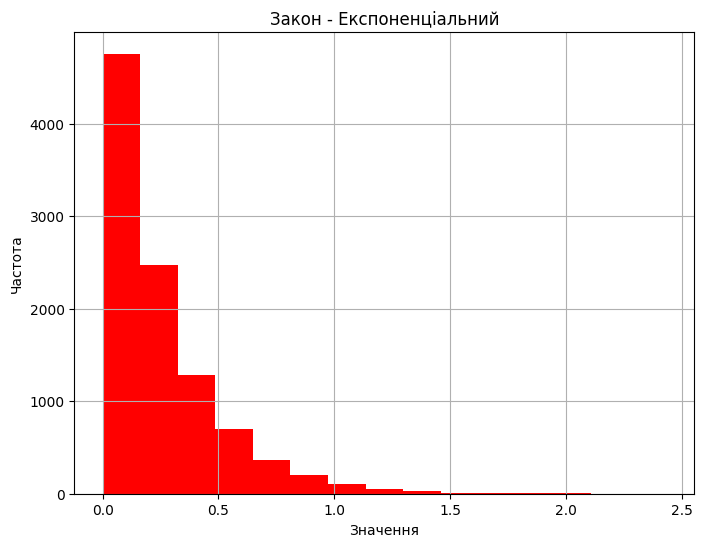

In [1526]:
observed_counts, bin_edges = np.histogram(exponential_samples, bins=num_bins)
print(observed_counts, bin_edges)
plot_histogram(
  exponential_samples, 
  num_bins, 
  title='Закон - Експоненціальний', 
  color='red'
  )

## Статистика за законом

In [1527]:
exponential_stats = calculate_sample_stats(exponential_samples)
sample_mean, sample_std = exponential_stats
formatted_chi2 = format_mean_std(exponential_stats, 'Експоненціальний')
print(formatted_chi2)

Експоненціальний: 
Середнє: 0.253, Std: 0.254


## Перевірка за критерієм згоди xi^2

In [1528]:
def prob_exponential(left: float, right: float, lambda_val: float) -> float:
    """Розраховує ймовірність потрапляння в інтервал [left, right) використовуючи різницю CDF."""
    return np.exp(-lambda_val * left) - np.exp(-lambda_val * right)

estimated_lambda = 1 / sample_mean
chi2 = calculate_chi2_statistic(
    sample_size, 
    observed_counts, 
    bin_edges, 
    prob_exponential, 
    estimated_lambda)

critical_value = get_chi2_critical_value(0.05, num_bins, 1)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Експоненціальний')
print(formatted_chi2)

Експоненціальний: 
Chi^2: 5.863, Chi^2 k: 22.362032494826934


In [1529]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Експоненціальний закон працює!")
else:
    print("Експоненціальний закон не працює!")

Експоненціальний закон працює!


# Нормальний закон розподілу

## Налаштування графіку гістограми

In [1530]:
sample_size = 10000
normal_init_bins = get_sturges_bin_count(sample_size)
print('Стовпці для гістограми нормального розподілу:', num_bins)

Стовпці для гістограми нормального розподілу: 15


## Формулювання закону розподілу

In [1531]:
sigma = 4 # Стандартне відхилення (scale)
multiplier_a = -5 # Математичне сподівання (loc)

# 1. Генерація матриці (N x 12) випадкових чисел
uniform_matrix = np.random.uniform(size=(sample_size, 12))

# 2. Отримання стандартного нормального розподілу N(0, 1)
# Згідно з центральною граничною теоремою: сума 12 рівномірних - 6 ≈ N(0, 1)
standard_normals = uniform_matrix.sum(axis=1) - 6

# 3. Трансформація до N(mean, sigma)
# Формула: X = sigma * Z + mean
normal_data = sigma * standard_normals + multiplier_a

print(normal_data)

# normal_law = np.zeros(sample_size)
# for idx in range(sample_size):
#     mu_value = np.random.uniform(size=12).sum() - 6
#     normal_law[idx] = sigma * mu_value + target_mean
# normal_law

[-5.98508374 -7.43888738 -5.1297656  ... -8.03068772 -4.19757625
 -9.13571148]


## Побудова графіку для перевірки закону

<Axes: title={'center': 'Закон - Нормальний розподіл'}, xlabel='Значення', ylabel='Частота'>

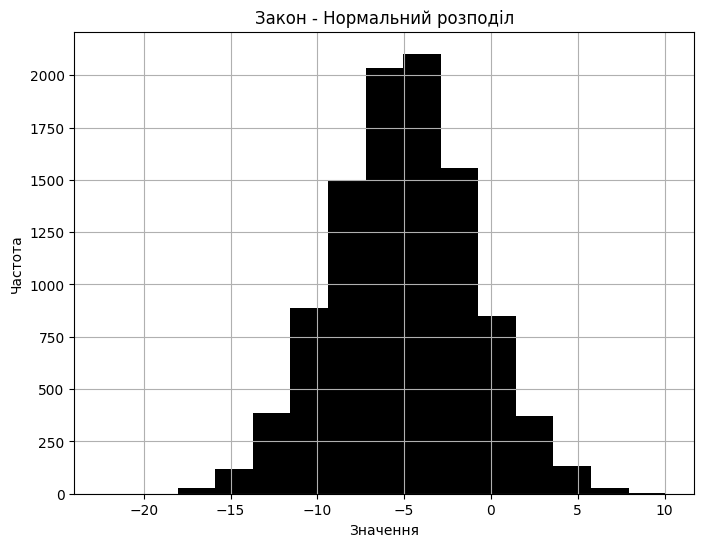

In [1532]:
observed_counts, bin_edges = np.histogram(normal_data, bins=normal_init_bins)
plot_histogram(
  normal_data, 
  bin_edges, 
  title='Закон - Нормальний розподіл', 
  color='black'
  )

## Статистика за законом

In [1533]:
sample_stats = calculate_sample_stats(normal_data)
sample_mean, sample_std = sample_stats
formatted_chi2 = format_mean_std(sample_stats, 'Нормальний розподіл')
print(formatted_chi2)

Нормальний розподіл: 
Середнє: -5.046, Std: 4.008


## Перевірка за критерієм згоди xi^2

In [1534]:
# Кумулятивна функція розподілу - cdf
def prob_normal(left: float, right: float, mean_val: float, std_val: float) -> float:
    """
    Розраховує площу під кривою Гауса між двома точками.
    loc = середнє (mean), scale = стандартне відхилення (std).
    """
    cdf_values = stats.norm.cdf([left, right], loc=mean_val, scale=std_val)
    return cdf_values[1] - cdf_values[0]

estimated_mean = sample_mean
estimated_std = sample_std
chi2 = calculate_chi2_statistic(
    sample_size, 
    observed_counts, 
    bin_edges, 
    prob_normal, 
    estimated_mean, 
    estimated_std
    )

critical_value = get_chi2_critical_value(0.05, normal_init_bins, 2)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Нормальний розподіл')
print(formatted_chi2)

Нормальний розподіл: 
Chi^2: 8.956, Chi^2 k: 21.02606981748307


In [1535]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Закон нормального розподілу працює!")
else:
    print("Закон нормального розподілу не працює!")

Закон нормального розподілу працює!


# Рівномірний закон розподілу

## Конфігурація графіку гістограми

In [1536]:
sample_size = 10000
num_bins = get_sturges_bin_count(sample_size)
print('Кількість інтервалів для Рівномірного розподілу:', num_bins)

Кількість інтервалів для Рівномірного розподілу: 15


## Формуляція закону розподілу

In [1537]:
multiplier_a = 5**13
modulus_m = 2**31
zi_value = np.random.uniform()

# Початкове значення (Seed / X_0)
# LCG працює з цілими числами, тому перетворюємо початковий float на int
current_x = int(np.random.uniform(1, modulus_m))

uniform_data = np.zeros(sample_size)

for i in range(sample_size):
    current_x = (multiplier_a * current_x) % modulus_m
    uniform_data[i] = current_x / modulus_m

print(uniform_data)


[0.88364495 0.30597219 0.08063958 ... 0.96921306 0.55367795 0.3065745 ]


## Побудова графіку для перевірки закону

<Axes: title={'center': 'Закон - Рівномірний розподіл'}, xlabel='Значення', ylabel='Частота'>

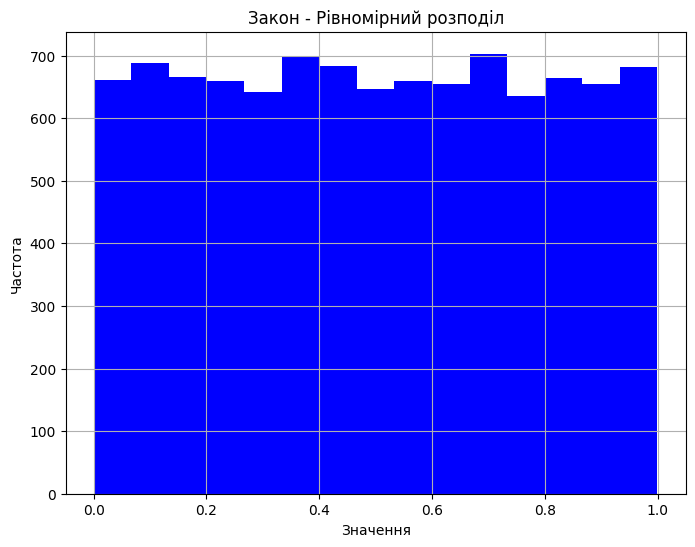

In [1538]:
uniform_counts, uniform_bins = np.histogram(uniform_data, bins=num_bins)
plot_histogram(uniform_data, uniform_bins, title='Закон - Рівномірний розподіл', color='blue')

## Статистика за законом

In [1539]:
uniform_stats = calculate_sample_stats(uniform_data)
uniform_mean, uniform_std = uniform_stats
formatted_chi2 = format_mean_std(uniform_stats, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Середнє: 0.499, Std: 0.289


## Перевірка за критерієм згоди xi^2

In [1540]:
def prob_uniform(left: float, right: float, lower_bound: float, upper_bound: float) -> float:
    """
    Розраховує ймовірність потрапляння в інтервал.
    PDF = 1 / (upper - lower).
    Ймовірність = Ширина_інтервалу * PDF.
    """
    l = max(left, lower_bound)
    r = min(right, upper_bound)
    
    if l >= r:
        return 0.0

    return (r - l) / (upper_bound - lower_bound)

estimated_lower = uniform_mean - 3 ** 0.5 * uniform_std
estimated_upper = uniform_mean + 3 ** 0.5 * uniform_std
chi2 = calculate_chi2_statistic(sample_size, uniform_counts, uniform_bins,
                            prob_uniform, estimated_lower, estimated_upper)
critical_value = get_chi2_critical_value(0.05, num_bins, 2)
formatted_chi2 = format_chi2_info(chi2, critical_value, 'Рівномірний розподіл')
print(formatted_chi2)

Рівномірний розподіл: 
Chi^2: 8.842, Chi^2 k: 21.02606981748307


In [1541]:
if is_hypothesis_accepted(chi2, critical_value):
    print("Закон рівномірного розподілу працює!")
else:
    print("Закон рівномірного розподілу не працює!")

Закон рівномірного розподілу працює!
